# 导入必要包

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import  Dataset,random_split,DataLoader

# 定义绘图函数

In [45]:
def plot_series(time,plot_series,format='-',start=0,end=None,label=None):
    plt.plot(time[start:end],plot_series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    plt.show()

# 数据生成函数的编写

In [46]:
def trend(time,slope=0):
    return (slope * time)
def whtie_noise(time,std=1.0,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time))*std
# 季节性周期模式
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))
def  seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time + phase) % period)/period
    return amplitude * seasonal_pattern(season_time)


# 数据集的生成
## 数据集的划分于batch的生成

In [47]:
def train_test_split(series,split_fraction=0.7):
    train_size = int(len(series) * split_fraction)
    train_set = series[:train_size]
    test_set = series[train_size:]
    return train_set,test_set
# 将数据集划分为指定的batch 大小
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    for i in range (0,num_examples,batch_size):
        #最后一次可能不满足一个batch
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)
    

## 滑动窗口的实现

In [48]:
import random
def data_process(train,test,windows_size):
    # print(train.shape)
    train_tensor = torch.from_numpy(train)
    train_windows_split=train_tensor.unfold(0,windows_size,1)
    train_set = train_windows_split.numpy()

    test_tensor = torch.from_numpy(test)
    test_windows_split=test_tensor.unfold(0,windows_size,1)
    test_set = test_windows_split.numpy()

    #将训练集短序列打乱
    train_temp1 = train_set.tolist()
    random.shuffle(train_temp1)
    train_temp2 = np.array(train_temp1)

    test_temp1 = test_set.tolist()
    # random.shuffle(test_temp1)
    test_temp2 = np.array(test_temp1)

    # 将短序列划分为 featrue label
    train_feature_array =  train_temp2[:,:windows_size-1]
    train_label_array = train_temp2[:,windows_size-1:]


    test_feature_array = test_temp2[:,:windows_size-1]
    test_label_array = test_temp2[:,windows_size-1:]

    # 将nparray 转为 tensor
    train_feature_tensor = torch.from_numpy(train_feature_array)
    train_label = torch.from_numpy(train_label_array)
    test_feature_tensor = torch.from_numpy(test_feature_array)
    test_label = torch.from_numpy(test_label_array)
    # 扩展数据维度，符合CNN输入
    train_feature = train_feature_tensor.reshape(train_feature_tensor.shape[0],1,train_feature_tensor.shape[1])
    test_feature = test_feature_tensor.reshape(test_feature_tensor.shape[0],1,test_feature_tensor.shape[1])

    return train_feature,train_label,test_feature,test_label

# 生成虚拟数据集

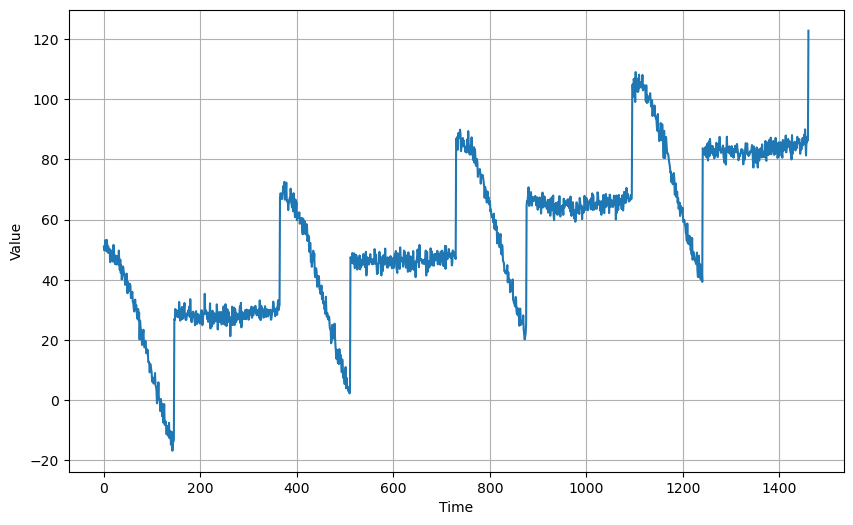

In [49]:
time = np.arange(4*365+1)
baseline = 10
slope = 0.05
amplitude = 40
noise_level = 2
series =  baseline + trend(time,slope) + seasonality(time,period=365,amplitude=amplitude)+whtie_noise(time,noise_level,seed=42)
# print(type(series))
series.astype(np.double)
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [50]:
import torch
from torch.utils.data import Dataset, DataLoader
split_prop = 0.7
train,test = train_test_split(series,split_prop)
windows_size =  6
# 调用data_process 进行数据处理
train_feature,train_label,test_feature,test_label = data_process(train,test,windows_size)
# 分别输出训练集，测试集的feature和label
batch_size = 128
# # 创建一个数据集类
# class MyDataset(Dataset):
#    def __init__(self, x,y):
#        self.x = x
#        self.y = y
      

#    def __len__(self):
#        return len(self.x)

#    def __getitem__(self, index):
#        return self.x[index], self.y[index]



# trian_set = MyDataset(train_feature,train_label)
# test_set = MyDataset(test_feature,test_label)

# train_loader = DataLoader(trian_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 数据处理

In [51]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# split_prop = 0.7
# train,test = train_test_split(series,split_prop)
# print(test)
# windows_size =  6
# # 调用data_process 进行数据处理
# train_feature,train_label,test_feature,test_label = data_process(train,test,windows_size)
# # 分别输出训练集，测试集的feature和label
# batch_size = 128
# # 创建一个数据集类
# class MyDataset(Dataset):
#    def __init__(self, x,y):
#        x  = x.to(torch.float32)
#        y  = y.to(torch.float32)
#        self.x = x
#        self.y = y


#    def __len__(self):
#        return len(self.x)

#    def __getitem__(self, index):
#        return self.x[index], self.y[index]

# a

# trian_set = MyDataset(train_feature,train_label)
# test_set = MyDataset(test_feature,test_label)

# train_loader = DataLoader(trian_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)



In [52]:
import torch
from torch.utils.data import Dataset, DataLoader
split_prop = 0.7
train,test = train_test_split(series,split_prop)
windows_size =  6
# 调用data_process 进行数据处理
train_feature,train_label,test_feature,test_label = data_process(train,test,windows_size)
# 分别输出训练集，测试集的feature和label
batch_size = 128
# # 创建一个数据集类
# class MyDataset(Dataset):
#    def __init__(self, x,y):
#        self.x = x
#        self.y = y
      

#    def __len__(self):
#        return len(self.x)

#    def __getitem__(self, index):
#        return self.x[index], self.y[index]



# trian_set = MyDataset(train_feature,train_label)
# test_set = MyDataset(test_feature,test_label)

# train_loader = DataLoader(trian_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# 定义神经网络

In [53]:
class ConvModel(nn.Module):
   def __init__(self):
       super(ConvModel,self).__init__()
       self.conv1 = nn.Sequential(
           nn.Conv1d(in_channels=1,out_channels=32,kernel_size=3,stride=1,padding=1),
           nn.ReLU(inplace=True)
       )
       self.conv2 = nn.Sequential(
           nn.Conv1d(in_channels=32,out_channels=64,kernel_size=2,stride=1,padding=1),
           nn.ReLU(inplace=True)
       )
       self.fc1=  nn.Linear(64,128)
       self.fc2 = nn.Linear(128,1)
   def forward(self,x):
    
       out =  self.conv1(x)
       out = F.avg_pool1d(out,2) # 平均池化
       out = self.conv2(out)
       out = F.avg_pool1d(out,2) # 平均池化层
       out = out.squeeze()
       out = self.fc1(out)
       out = self.fc2(out)
       return out




In [54]:
# 训练模型

lr  = 0.01
epoch = 500

net = ConvModel()
opt = torch.optim.Adam(net.parameters(),lr=lr)
for param in net.parameters():
    torch.nn.init.normal_(param,mean=0,std=0.01)
def loss(x,y):
    return (net(x)-y)**2/2

train_loss = []
test_loss = []
for epoch_num in range(epoch):
    train_list = []
    test_list = []
    for x,y in data_iter(batch_size,train_feature,train_label):
        # print(y.shape)
        x =  x.to(torch.float32)
        y = y.to(torch.float32)
        l = loss(x,y).mean()
        if opt is not None:
            opt.zero_grad()
        elif params is not None and params[0].grad is not None:
            for param in params:
                param.grad.data.zero_()
        l.backward()
        opt.step()
      
        train_list.append(l.item())
    for x,y in data_iter(batch_size,test_feature,test_label):
        x =  x.to(torch.float32)
        y = y.to(torch.float32)
        l = loss(x,y).mean()
        test_list.append(l.item())
    test_loss.append(np.mean(test_list))
    train_loss.append(np.mean(train_list))
    print("epoch:",epoch_num+1,
          "train_loss:",np.mean(test_list),
          "test_loss:", np.mean(train_list)
          )

epoch: 1 train_loss: 819.0610046386719 test_loss: 755.5291814804077
epoch: 2 train_loss: 15.768692970275879 test_loss: 120.54545164108276
epoch: 3 train_loss: 169.20603561401367 test_loss: 48.16602265834808
epoch: 4 train_loss: 33.24844932556152 test_loss: 32.344701051712036
epoch: 5 train_loss: 20.749139308929443 test_loss: 22.59691059589386
epoch: 6 train_loss: 16.25628936290741 test_loss: 17.015666246414185
epoch: 7 train_loss: 16.163093090057373 test_loss: 15.187230050563812
epoch: 8 train_loss: 19.798864245414734 test_loss: 14.405985653400421
epoch: 9 train_loss: 19.92762327194214 test_loss: 14.361696004867554
epoch: 10 train_loss: 19.115784168243408 test_loss: 14.42150616645813
epoch: 11 train_loss: 18.775762915611267 test_loss: 14.395135879516602
epoch: 12 train_loss: 19.52243733406067 test_loss: 14.262077391147614
epoch: 13 train_loss: 19.514147758483887 test_loss: 14.084486484527588
epoch: 14 train_loss: 14.266196370124817 test_loss: 13.182372391223907
epoch: 15 train_loss: 13

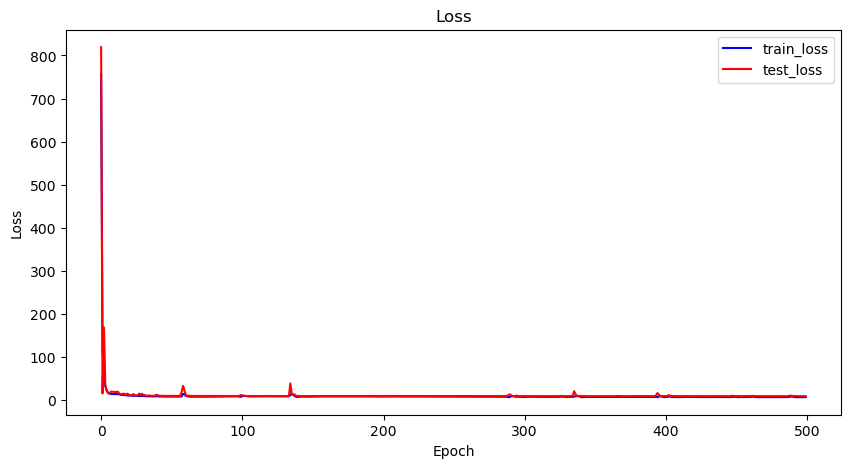

In [55]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(len(train_loss)),train_loss, 'b-',label="train_loss")
plt.plot(range(len(train_loss)),test_loss, 'r-' ,label="test_loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

# 模型预测

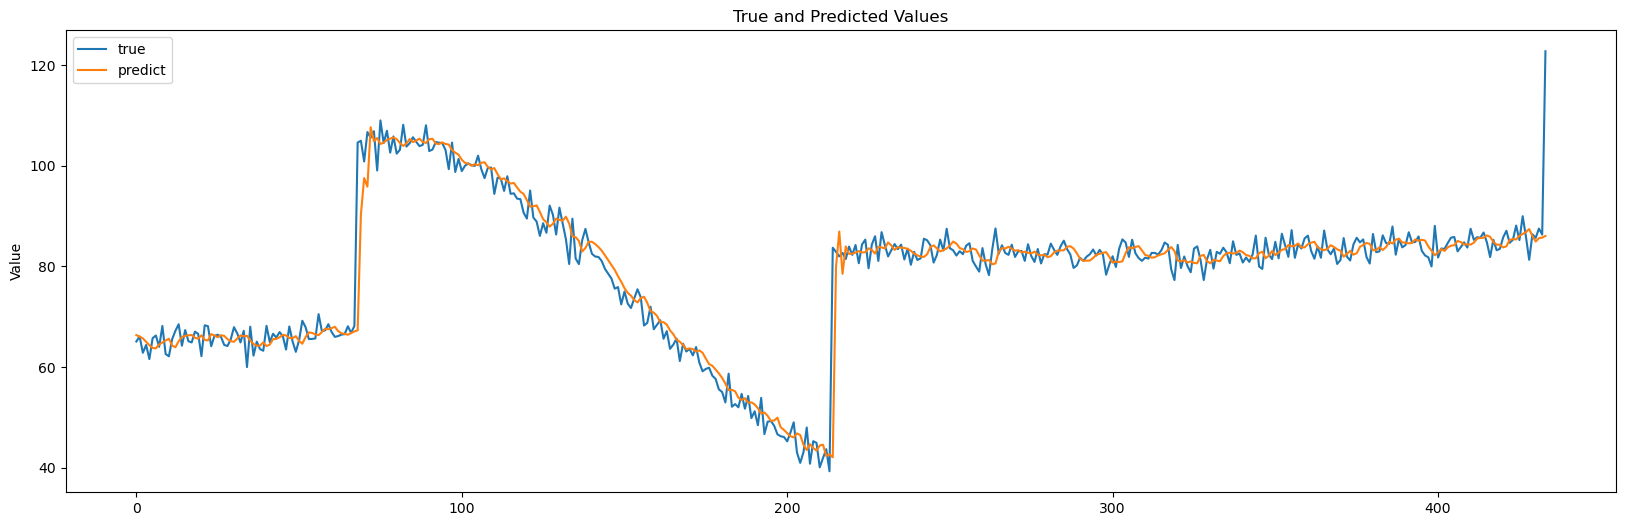

In [56]:

test_predict=[]
split_point = int(split_prop*int(series.size))

# 测试集真实序列
test_true = test
# 测试集预测序列

test_predict = net(test_feature.to(torch.float32)).squeeze().tolist()

plt.figure(figsize=(20, 6))
plt.plot(test_label, label='true')
plt.plot(test_predict, label='predict')
plt.ylabel('Value')
plt.title('True and Predicted Values')
plt.legend()
plt.show()